                                                                                                MSC 10-2022

# Filtering

- [**Imports**](#Imports)
- [**Introduction**](#Introduction)
- [**Finite Impulse Response Filters (FIR)**](#Finite-Impulse-Response-Filters-(FIR))
    - [**Mathematics**](#Mathematics)
    - [**Design Methods**](#Design-Method)
        - [**FIR Filter Design in Openseize**](#FIR-Filter-Design-in-Openseize)
        - [**General Cosine Windows**](#General-Cosine-Windows)
        - [**Kaiser Windows**](#Kaiser-Windows)
        - [**Minimax Window Method**](#Minimax-Window-Method)
        - [**Practical Considerations & Recommendations**](#Practical-Considerations-&-Recommendations)
- [**Infinite Impulse Response Filters (IIR)**](#Infinite-Impulse-Response-Filters-(FIR))
    - [**Mathematics**](#Mathematics)
    - [**IIR Filter Design in Openseize**](#IIR-Filter-Design-in-Openseize)
    - [**Transfer Function Coeffecient Formats**](#Transfer-Function-Coeffecient-Formats)
    - [**Practical Considerations & Recommendations**](#Practical-Considerations-&-Recommendations)
- [**Notch Filters**](#Notch-Filters) 
- [**Appendix**](#Appendix)

## Imports

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from openseize import filtering

## Introduction

This tutorial covers the mathematics, design and application of filters in Openseize. Since this is a deep subject, the tutorial can be approached in two ways. First, readers that are interested in understanding the principles that govern filter design methods, the sections headed by "Mathematics" are a starting point and include references for deeper study. Second, readers who are only interested in the practical implementation of each filter can safely skip these sections but be sure to carefully read the "Practical Considerations and Recommendations" sections.
</br>
</br>
Lastly it is important to remember that there are two stages to filtering data. The first is to design a filter that meets a specific set of design criteria and second to apply the filter to a potentially very large data set. Openseize streamlines these two processes by allowing clients to create filter objects with methods that handle both the filter design and the iterative application of the filter to data that may not fit into RAM. The application of the filter to large data is carried out using the overlap-add method for FIR filters and initial conditioning for IIR filters. This tutorial does not specifically address those algorithms. For details on this iterative implementation of filters, please see the openseize.numerical module. It has detailed documentation on the nitty-gritty of applying filters to large datasets.  

## Finite Impulse Response Filters (FIR)

### Mathematics

A Finite Impulse Response filter is a set of coeffecients $h[n]$ used to weight previous signal samples $x[n]$ to yield each filtered output $y[n]$.
</br>
</br>
<center> $y[n] = \sum \limits_{i=0}^{N} h[i] \ x[n-i] \quad (1)$ </center>

This operation, called convolution, requires N multiplications and N additions for each output value $y[n]$.
<b> Our goal is to find a set of N coeffecients for $h$ such that the frequency response of the filter meets a set of design criteria while keeping the filter order, N, low.</b>. 
</br>
</br>

Openseize defaults to using Type I FIR filters which means that that the filter order is an even number N=2M and the filter has an initial phase $\phi_0 = 0$. Since the sum in (1) runs from 0 to N there are N+1 total terms. This number (N+1) is called the number of taps. To find a good set of coeffecients for h, we start by defining what the ideal response of the filter should be in the frequency domain. To keep things general lets assume we are designing a bandpass filter from $\theta_1$ to $\theta_2$ where $\theta$ is in units of rads/sec.

The <b>ideal amplitude response</b> of our bandpass filter is then:
</br>
</br>
<center> $A_{d}(\theta) = \begin{cases}
                            1 & \theta_1 \leq |\theta| \leq \theta_2 \\
                            0 & otherwise
                       \end{cases} \quad (2)$
</center>
</br>
</br>
Lets now write a function that creates this ideal amplitude response and plot an example.

In [28]:
def ideal_amplitude_response(low, high, n=1000):
    """Creates the ideal amplitude response of a bandpass filter.
    
    Args:
        low: float
            The low frequency cutoff in rads/sec.
        high: float
            The high frequency cutoff in rads/sec.
        n: int
            The number of frequencies between 0 and Nyquist = pi radians to return amplitudes at. 
            Default is 1000 frequencies.
            
    Returns: An array of frequencies between 0 and 1 and an array of corresponding amplitudes.
    """
    
    thetas = np.linspace(0, 1, 1000)
    amplitudes = (thetas >= low / np.pi) & (thetas <= high / np.pi)
    return thetas, amplitudes

In [32]:
def plot_ideal_response(thetas, amplitudes, ax, n=1000):
    """Plots the ideal amplitude response of a bandpass filter to an axis.
    
    Args:
        thetas: 1-D array
            Array of frequencies between 0 and 1.
        amplitudes: 1-D array
            Array of amplitudes, one for each theta in thetas.
        ax: mpl axis
            A matplotlib axis to display to.
        n: int
            The number of frequencies between 0 and Nyquist = pi radians to return amplitudes at. 
            Default is 1000 frequencies.
    """
    
    ax.plot(thetas, amplitudes, color='k')
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.set_xlabel(r'$\theta$', fontsize=14)
    ax.set_ylabel(r'$A_d(\theta)$', fontsize=14)

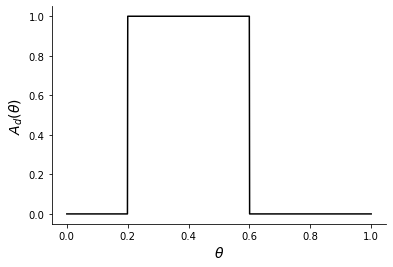

In [33]:
low = 0.2 * np.pi
high = 0.6 * np.pi
thetas, amplitudes = ideal_amplitude_response(low, high, n=1000)

fig, ax = plt.subplots()
plot_ideal_response(thetas, amplitudes, ax)
plt.show()

The ideal amplitude response (Eq. 2) is part of the <b>ideal frequency response</b> $H_d^f(\theta)$ of the FIR filter. The frequency response includes the amplitude response and the phase of the filter.
</br>
</br>
<center>$H_d^f(\theta) = A_d(\theta)\ e^{-i\theta N/2} \quad (3) $ </center>

The phase delay tells us that the filtered output y[n] will be **delayed** relative to x[n]. For Type I FIR filters (openseize's default), this delay is a constant N/2.
</br>
</br>
<b>Remember our goal, we want to find $h[n]$</b>. Since we have the ideal frequency response (3) we can use the inverse Fourier transform to get the ideal/desired filter $h_d[n]$.
</br>
</br>
By substituting 2 into 3 and taking the inverse Fourier transform we get $h_d[n]$ also called the ideal impulse response:

<center> $h_d[n] = \frac{1}{2\pi} \int \limits_{-\theta_2}^{\theta_1}e^{i \theta (n-N/2)} d\theta + \frac{1}{2\pi} \int \limits_{\theta_1}^{\theta_2}e^{i \theta (n-N/2)}d\theta \quad (4)$
</br>
</br>
$= \frac{\sin(\theta_2(n-N/2))}{\pi(n-N/2)} - \frac{\sin(\theta_1(n-N/2))}{\pi(n-N/2)} \quad (5)$
</br>
</br>
$= \frac{\theta_2}{\pi}sinc[\frac{\theta_2(n-N/2)}{\pi}]- \frac{\theta_1}{\pi}sinc[\frac{\theta_1(n-N/2)}{\pi}] \quad (6)$

Notice that $h_d[n]$ is a <b>function</b> of n where n is an integer, it is <b>defined for all integers n!</b> So in order to create a filter we can actually apply, we must <font color='firebrick'><b><u>TRUNCATE</b></u></font> $h_d[n]$. 
</br>
</br>
<center> $h[n] = \begin{cases}
                            h_d[n] & 0 \leq n \leq N \\
                            0 & otherwise
                       \end{cases} \quad (7)$
</center>

Lets build a function that computes the truncated impulse response $h[n]$.

In [10]:
def truncated_impulse(low, high, N):
    """Returns a truncated impulse response function h[n] of a Type I FIR.
    
    Args:
        low: float
            The low frequency cutoff in rads/sec.
        high: float
            The high frequency cutoff in rads/sec.
        N: int
            The order of the filter. Must be an even number
            
    Returns: An array of truncated filter coeffecients
    """
    
    ns = np.arange(N)
    
    #Eq 6
    return high/np.pi * np.sinc(high/np.pi * (ns - N//2)) - low/np.pi * np.sinc(low/np.pi * (ns - N//2))

In [24]:
def plot_impulse(h, ax):
    """Plots the impulse response to a matplotlib axis."""
    
    ax.stem(h, label='N = {}'.format(len(h)))
    ax.set_ylabel('h[n]', fontsize=14)
    ax.set_xlabel('n', fontsize=14)
    ax.legend()

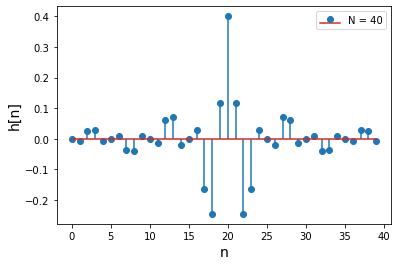

In [25]:
# show the impulse response for our example bandpass filter
h = truncated_impulse(low, high, N=40)
fig, ax = plt.subplots()
plot_impulse(h, ax)
plt.show()

<b>What does truncating the impulse response $h_d[n] \rightarrow h[n]$ do to the ideal amplitude response $A_d(\theta) \rightarrow \ ?$

The frequency response of the filter is the Fourier transform of the truncated impulse response $h[n]$.
</br>
</br>
<center>$H^f(\theta) = \sum \limits_{n=0}^{2M}h[n]e^{-i \theta n} \quad (8)$ </center>
</br>
</br>
Since Type I FIR filters are symmetric $h[n] = h[N-n]$ where N=2M is the length of the filter. Using this symmetry we can write:
</br>
</br>
<center>
$
\begin{align}
H^f(\theta) &= \sum \limits_{n=0}^{2M}h[n]e^{-i \theta n} =  \sum \limits_{n=0}^{2M} h[n]e^{-i \theta M}e^{i \theta (M-n)} \\
&= e^{-i \theta M} \left\{\sum \limits_{n=0}^{2M} h[n] \ e^{i \theta (M-n)} \right\} \\
&= e^{-i \theta M} \left\{h[M] + \sum \limits_{n=0}^{M-1} h[n] \ e^{i \theta (M-n)} + \sum \limits_{n=M+1}^{2M} h[n] \ e^{i \theta (M-n)}\right\}\\
& \ letting \ n' =  N-n \ and \ rename \ n' = n\\
&= e^{-i \theta M} \left\{h[M] + \sum \limits_{n=0}^{M-1} h[n] \ e^{i \theta (M-n)} + \sum \limits_{n=0}^{M-1} h[N-n] \ e^{i \theta (M-n)}\right\}\\
&= e^{-i \theta M} \left\{h[M] + 2 \sum \limits_{n=0}^{M-1} h[n]cos[\theta (M-n)] \right\} \quad (8)
\end{align}
$
</center>
</br>
So the amplitude response after truncation is:
<center>
    $A(\theta) = \left\{h[M] + 2 \sum \limits_{n=0}^{M-1} h[n]cos[\theta (M-n)] \right\} \quad (9)$
</center>

Lets write a function for the truncated amplitude response.

In [27]:
def amplitude_response(h, nthetas=1000):
    """Returns the amplitude response of a truncated Type I FIR filter (Eq. 9).
    
    Args:
        h: 1-D array
            An array of truncated filter coeffecients.
        nthetas: int
            The number of frequencies in rads/sec to evaluate the amplitude response at.
            
    Returns:
        A 1-D array of size nthetas from 0 to 1 and a 1-D array of size nthetas of amplitude responses.
    """
    
    M = len(h) // 2
    thetas = np.linspace(0, np.pi, nthetas)
    
    # initialize the results at each theta with h[M]
    result = h[M] * np.ones(nthetas)
    
    # add the sum contribution to each theta in result
    for idx, theta in enumerate(thetas):
        
        result[idx] += np.sum([2 * h[M-n] * np.cos(theta * n) for n in range(1, M+1)])
    
    return thetas, result
    

In [34]:
# lets also make a function that will plot the amplitude response
def plot_response(thetas, response, ax):
    """Plots the truncated amplitude response to a matplotlib axis."""
    
    ax.plot(thetas, response)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.set_xlabel(r'$\theta$', fontsize=14)
    ax.set_ylabel(r'$A(\theta)$', fontsize=14)

Ok so lets pause and review what we have. We have the ideal amplitude response $A_d(\theta)$ that we want to approximate, we have a truncated impulse response $h[n]$ and we have the truncated amplitude response $A(\theta)$. So lets compare how well the truncated amplitude response matches our desired ideal response for a range of filter orders.

In [ ]:
#draw together the truncated impulse responses and amplitude responses for several different orders of filters
#for our bandpass example

In [26]:
#DEPRECATE!!!!!!!!!!!!!
n40 = np.arange(0, 40)
n80 = np.arange(0, 80)

hd_40 = theta2 * np.sinc(theta2 * (n40 - 40/2)) - \
        theta1 * np.sinc(theta1 * (n40 - 40/2))

# see 9.5 for amplitude response
def amplitude_response(h, thetas=np.linspace(0, np.pi, 1000)):
    """ """
    
    M = len(h)//2
    result = []
    for theta in thetas:
        term = 0
        for n in range(0, M+1):
            if n==0:
                term = h[M]
            else:
                term += 2*h[M-n]*np.cos(theta*n)
        result.append(term)
    return result
        
Ad_40 = amplitude_response(hd_40)
    
#Ad_40 = np.abs(np.fft.fft(hd_40, n=512, axis=0))

hd_80 = theta2 * np.sinc(theta2 * (n80 - 80/2)) - \
        theta1 * np.sinc(theta1 * (n80 - 80/2))
Ad_80 = amplitude_response(hd_80)

fig, axarr = plt.subplots(1, 2, figsize=(10,4))
axarr[0].stem(hd_40)
axarr[1].plot(thetas, amplitudes, label=r'$A_d(\theta)$')
f = np.linspace(0,1, len(Ad_80))
axarr[1].plot(f, Ad_80)
plt.show()

NameError: name 'theta2' is not defined